# **Customer Segmentation**

**Subject:** BADS7105 - CRM Analytics and Intelligence

**Student:** Nathachok Namwong (6210422007)

# Initialization

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import scale, StandardScaler

# Read Data from BigQuery

In [2]:
from google.colab import auth
auth.authenticate_user()

In [4]:
project_id = 'nida-bads-7105'

SQL = '''
SELECT
    S.CUST_CODE,
    SUM(S.SPEND) AS TOTAL_SPEND,
    AVG(M.MONTHLY_SPEND) AS AVG_MONTHLY_SPEND,
    STDDEV_POP(M.MONTHLY_SPEND) AS STD_MONTHLY_SPEND,
    COUNT(DISTINCT S.BASKET_ID) AS TOTAL_VISIT,
    AVG(M.MONTHLY_VISIT) AS AVG_MONTHLY_VISIT,
    STDDEV_POP(M.MONTHLY_VISIT) AS STD_MONTHLY_VISIT,
    CASE
    WHEN SUM(CASE WHEN S.BASKET_SIZE='L' THEN 1 ELSE 0 END) >= SUM(CASE WHEN S.BASKET_SIZE='S' THEN 1 ELSE 0 END)
     AND SUM(CASE WHEN S.BASKET_SIZE='L' THEN 1 ELSE 0 END) >= SUM(CASE WHEN S.BASKET_SIZE='M' THEN 1 ELSE 0 END) THEN 3
    WHEN SUM(CASE WHEN S.BASKET_SIZE='M' THEN 1 ELSE 0 END) >= SUM(CASE WHEN S.BASKET_SIZE='S' THEN 1 ELSE 0 END)
     AND SUM(CASE WHEN S.BASKET_SIZE='M' THEN 1 ELSE 0 END) >= SUM(CASE WHEN S.BASKET_SIZE='L' THEN 1 ELSE 0 END) THEN 2
    WHEN SUM(CASE WHEN S.BASKET_SIZE='S' THEN 1 ELSE 0 END) >= SUM(CASE WHEN S.BASKET_SIZE='M' THEN 1 ELSE 0 END)
     AND SUM(CASE WHEN S.BASKET_SIZE='S' THEN 1 ELSE 0 END) >= SUM(CASE WHEN S.BASKET_SIZE='L' THEN 1 ELSE 0 END) THEN 1
    END AS MODE_BASKET_SIZE,
    DATE_DIFF(PARSE_DATE('%Y%m%d', CAST(MAX(S.SHOP_DATE) AS STRING)), PARSE_DATE('%Y%m%d', CAST(MIN(S.SHOP_DATE) AS STRING)), DAY) AS CUST_LIFETIME,
    DATE_DIFF(DATE'2008-07-06', PARSE_DATE('%Y%m%d', CAST(MIN(S.SHOP_DATE) AS STRING)), DAY) AS DURATION_FROM_FIRST_PURCHASE,
    DATE_DIFF(DATE'2008-07-06', PARSE_DATE('%Y%m%d', CAST(MAX(S.SHOP_DATE) AS STRING)), DAY) AS DURATION_FROM_LAST_PURCHASE
FROM
    `nida-bads-7105.supermarket.supermarket-data` AS S
INNER JOIN (
    SELECT
        CUST_CODE,
        LEFT(CAST(SHOP_DATE AS STRING), 6) AS SHOP_MONTH,
        SUM(SPEND) AS MONTHLY_SPEND,
        COUNT(DISTINCT BASKET_ID) AS MONTHLY_VISIT
    FROM
        `nida-bads-7105.supermarket.supermarket-data`
    GROUP BY
        CUST_CODE, SHOP_MONTH
) AS M ON S.CUST_CODE = M.CUST_CODE
WHERE
    S.CUST_CODE IS NOT NULL
GROUP BY
    S.CUST_CODE
ORDER BY
    S.CUST_CODE
'''

df = pd.io.gbq.read_gbq(SQL, project_id=project_id)

In [5]:
df.head(10)

,CUST_CODE,TOTAL_SPEND,AVG_MONTHLY_SPEND,STD_MONTHLY_SPEND,TOTAL_VISIT,AVG_MONTHLY_VISIT,STD_MONTHLY_VISIT,MODE_BASKET_SIZE,CUST_LIFETIME,DURATION_FROM_FIRST_PURCHASE,DURATION_FROM_LAST_PURCHASE
0,CUST0000000181,2.44,2.440000,0.000000,1,1.000000,0.000000,1,0,547,547
1,CUST0000000369,26861.24,34.261786,20.446128,220,7.857143,3.388155,2,811,812,1
2,CUST0000000689,2957.13,36.507778,36.112964,16,1.777778,1.227262,3,337,350,13
3,CUST0000000998,11.90,2.975000,2.135000,3,1.500000,0.500000,1,64,794,730
4,CUST0000001163,158.96,9.935000,9.546134,4,1.000000,0.000000,3,609,623,14
5,CUST0000001194,67333.41,92.364074,50.744659,103,3.814815,1.806102,3,790,806,16
6,CUST0000002257,1.99,1.990000,0.000000,1,1.000000,0.000000,1,0,716,716
7,CUST0000002499,0.34,0.340000,0.000000,1,1.000000,0.000000,1,0,814,814
8,CUST0000002605,9.00,0.360000,0.120000,6,1.200000,0.400000,1,613,637,24
9,CUST0000002637,1370.93,11.330000,5.284480,15,1.363636,0.642824,3,666,703,37


# Clustering Model

In [6]:
Features = ['AVG_MONTHLY_SPEND','STD_MONTHLY_SPEND','AVG_MONTHLY_VISIT','STD_MONTHLY_VISIT','MODE_BASKET_SIZE','CUST_LIFETIME','DURATION_FROM_LAST_PURCHASE']

X = df[Features]
X_std = pd.DataFrame(StandardScaler().fit_transform(X))

Text(0, 0.5, 'Silhouette Score')

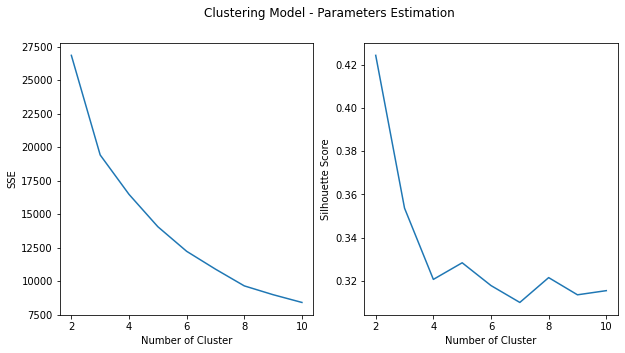

In [8]:
sse = []
sil = []
n = range(2, 11)

for i in n:
  kmeans = KMeans(n_clusters=i, n_init=50).fit(X_std)
  sse.append(kmeans.inertia_)
  sil.append(silhouette_score(X_std, kmeans.labels_, metric='euclidean'))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
fig.suptitle('Clustering Model - Parameters Estimation')

ax1.plot(n, sse)
ax1.set_xlabel('Number of Cluster')
ax1.set_ylabel('SSE')

ax2.plot(n, sil)
ax2.set_xlabel('Number of Cluster')
ax2.set_ylabel('Silhouette Score')

In [30]:
df_cluster = df.copy()
df_cluster['CLUSTER'] = KMeans(n_clusters=3, n_init=50, random_state=10).fit_predict(X_std)

In [32]:
df_cluster.head(10)

,CUST_CODE,TOTAL_SPEND,AVG_MONTHLY_SPEND,STD_MONTHLY_SPEND,TOTAL_VISIT,AVG_MONTHLY_VISIT,STD_MONTHLY_VISIT,MODE_BASKET_SIZE,CUST_LIFETIME,DURATION_FROM_FIRST_PURCHASE,DURATION_FROM_LAST_PURCHASE,CLUSTER
0,CUST0000000181,2.44,2.440000,0.000000,1,1.000000,0.000000,1,0,547,547,0
1,CUST0000000369,26861.24,34.261786,20.446128,220,7.857143,3.388155,2,811,812,1,2
2,CUST0000000689,2957.13,36.507778,36.112964,16,1.777778,1.227262,3,337,350,13,1
3,CUST0000000998,11.90,2.975000,2.135000,3,1.500000,0.500000,1,64,794,730,0
4,CUST0000001163,158.96,9.935000,9.546134,4,1.000000,0.000000,3,609,623,14,1
5,CUST0000001194,67333.41,92.364074,50.744659,103,3.814815,1.806102,3,790,806,16,2
6,CUST0000002257,1.99,1.990000,0.000000,1,1.000000,0.000000,1,0,716,716,0
7,CUST0000002499,0.34,0.340000,0.000000,1,1.000000,0.000000,1,0,814,814,0
8,CUST0000002605,9.00,0.360000,0.120000,6,1.200000,0.400000,1,613,637,24,1
9,CUST0000002637,1370.93,11.330000,5.284480,15,1.363636,0.642824,3,666,703,37,1


# Feature Importance

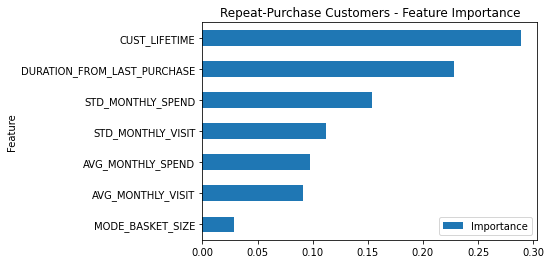

In [33]:
X = df_cluster[Features]
y = df_cluster['CLUSTER']

clf = RandomForestClassifier(criterion = 'entropy').fit(X, y)

df_importance = pd.DataFrame({'Feature': Features, 'Importance' : clf.feature_importances_}).set_index('Feature')
df_importance.sort_values('Importance').plot.barh(title='Repeat-Purchase Customers - Feature Importance')

# Exploratory Data Analysis

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


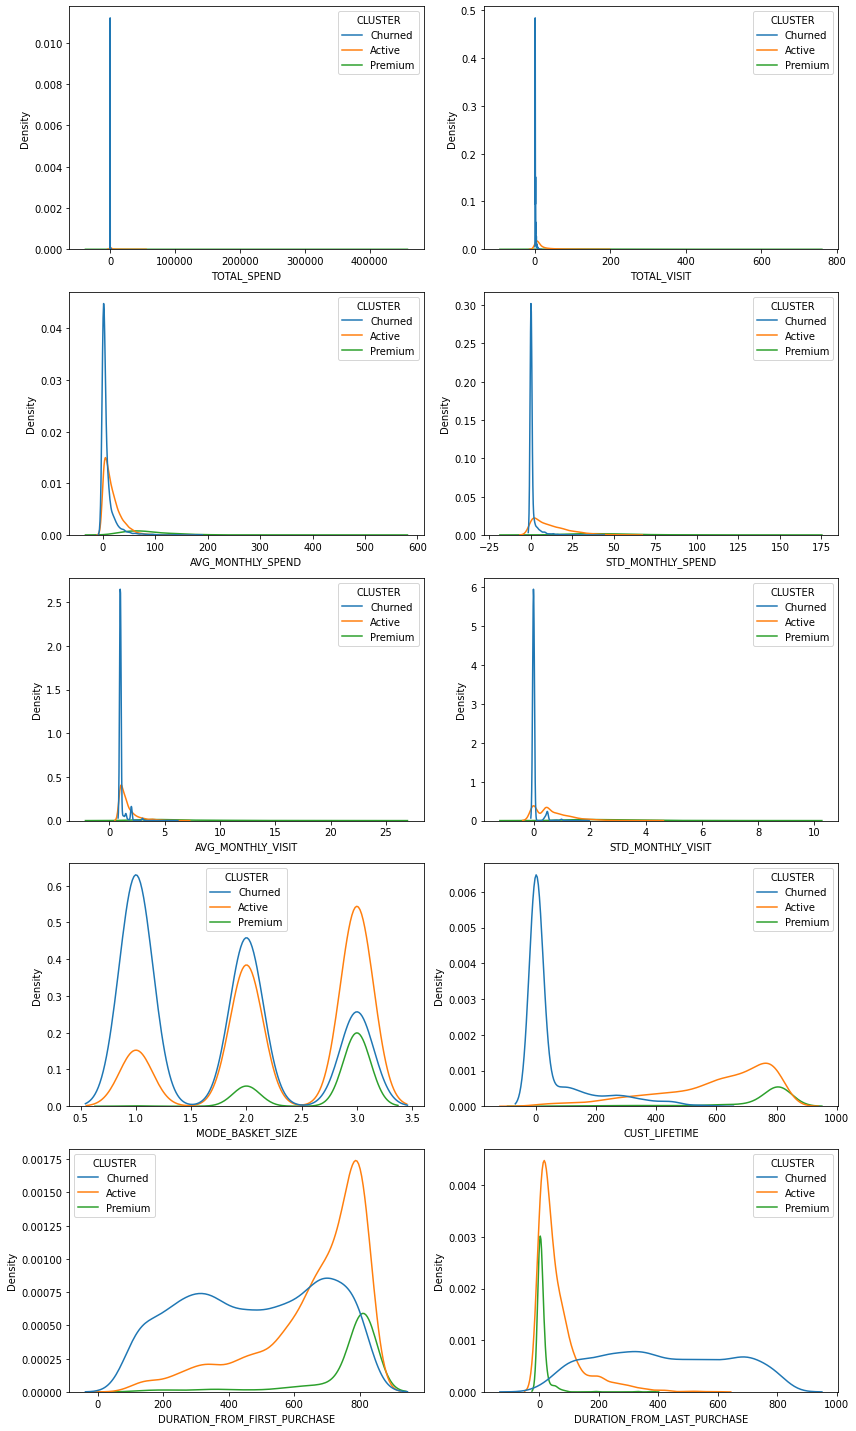

In [45]:
df_eda = df_cluster[['CLUSTER','TOTAL_SPEND','TOTAL_VISIT','AVG_MONTHLY_SPEND','STD_MONTHLY_SPEND','AVG_MONTHLY_VISIT',
                     'STD_MONTHLY_VISIT','MODE_BASKET_SIZE','CUST_LIFETIME','DURATION_FROM_FIRST_PURCHASE','DURATION_FROM_LAST_PURCHASE']]
df_eda.sort_values(by=['CLUSTER'], inplace=True)
df_eda['CLUSTER'].replace({0:'Churned',1:'Active',2:'Premium'}, inplace=True)

fig, axes = plt.subplots(5, 2, figsize=(12, 20), tight_layout=True)
axes = axes.ravel()
for col, ax in zip(df_eda.iloc[:,1:].columns, axes):
  sns.kdeplot(data=df_eda, x=col, hue='CLUSTER', palette='tab10', ax=ax)

plt.show()

# Interpretation

In [31]:
df_interpret = df_cluster.groupby('CLUSTER', as_index=False).mean()
df_interpret['NO_CUST'] = df_cluster[['CLUSTER','CUST_CODE']].groupby('CLUSTER').count()

df_interpret

,CLUSTER,TOTAL_SPEND,AVG_MONTHLY_SPEND,STD_MONTHLY_SPEND,TOTAL_VISIT,AVG_MONTHLY_VISIT,STD_MONTHLY_VISIT,MODE_BASKET_SIZE,CUST_LIFETIME,DURATION_FROM_FIRST_PURCHASE,DURATION_FROM_LAST_PURCHASE,NO_CUST
0,0,23.647140,8.163846,0.888009,1.702487,1.102836,0.040120,1.722895,57.748724,479.413584,421.664860,3136
1,1,3215.342758,17.970613,11.440702,18.441129,1.602518,0.626672,2.362097,595.596371,658.140323,62.543952,2480
2,2,52218.730393,86.644517,44.726162,146.911157,6.086115,2.652220,2.776860,740.867769,751.770661,10.902893,484


# Export Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

df_cluster.to_csv('/content/drive/MyDrive/NIDA BA&I/BADS7105/Homework 6/Supermarket Cluster.csv', index=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
